In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from PIL import Image

In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rokhmatfebrianto","key":"4ab62fb9df572429a29170394dcb244f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d madisona/translated-animals10

 98% 576M/586M [00:03<00:00, 177MB/s]
100% 586M/586M [00:03<00:00, 169MB/s]


In [5]:
# unzip
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

animals10


In [6]:
animals = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(animals))

['chicken', 'squirrel', 'dog', 'horse', 'elephant', 'cat', 'butterfly', 'cow', 'sheep', 'spider']


In [7]:
ignore = ['squirrel', 'cat', 'sheep', 'cow', 'elephant']

for x in ignore:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [8]:
list_animals = os.listdir(animals)
print(list_animals)

['chicken', 'dog', 'horse', 'butterfly', 'spider']


In [9]:
tot = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  tot = tot + y
  
  img_name = os.listdir(dir)

  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal Image :', tot)

chicken: 3098
- (300, 273)
- (300, 225)
- (269, 300)
- (251, 300)
---------------
dog: 4863
- (282, 300)
- (201, 300)
- (300, 300)
- (300, 225)
---------------
horse: 2623
- (300, 169)
- (300, 240)
- (300, 169)
- (300, 225)
---------------
butterfly: 2112
- (300, 201)
- (300, 225)
- (300, 300)
- (640, 426)
---------------
spider: 4821
- (300, 225)
- (300, 240)
- (300, 193)
- (300, 200)
---------------

Total Image : 17517


**Dataset dibagi menjadi 80% train set dan 20% test set.**

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2    # Dataset dibagi menjadi 80% train set dan 20% test set.   
)

In [11]:
batch_size = 256
img_height = 180
img_width = 180

In [12]:
train_ds = train_datagen.flow_from_directory(
  animals,
  subset="training",
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = train_datagen.flow_from_directory(
  animals,
  subset="validation",
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 14016 images belonging to 5 classes.
Found 3501 images belonging to 5 classes.


In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
number_classes = 5
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(number_classes, activation='softmax')
])

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [18]:
number_epochs = 50

history = model.fit(train_ds, 
                    epochs = number_epochs, 
                    steps_per_epoch = train_ds.samples // batch_size,
                    validation_data = val_ds, 
                    validation_steps = val_ds.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/50
54/54 [==============================] - 201s 3s/step - loss: 1.4884 - accuracy: 0.3191 - val_loss: 1.3985 - val_accuracy: 0.3981
Epoch 2/50
54/54 [==============================] - 162s 3s/step - loss: 1.3237 - accuracy: 0.4344 - val_loss: 1.2701 - val_accuracy: 0.4657
Epoch 3/50
54/54 [==============================] - 161s 3s/step - loss: 1.1627 - accuracy: 0.5350 - val_loss: 1.0753 - val_accuracy: 0.5757
Epoch 4/50
54/54 [==============================] - 161s 3s/step - loss: 1.0335 - accuracy: 0.6011 - val_loss: 0.9518 - val_accuracy: 0.6370
Epoch 5/50
54/54 [==============================] - 161s 3s/step - loss: 0.8971 - accuracy: 0.6602 - val_loss: 0.8878 - val_accuracy: 0.6638
Epoch 6/50
54/54 [==============================] - 160s 3s/step - loss: 0.8415 - accuracy: 0.6807 - val_loss: 0.8523 - val_accuracy: 0.6749
Epoch 7/50
54/54 [==============================] - 159s 3s/step - loss: 0.7635 - accuracy: 0.7198 - val_loss: 0.7371 - val_accuracy: 0.7178
Epoch 8/50
54

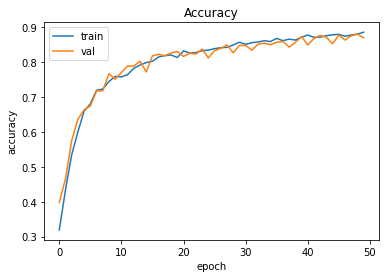

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

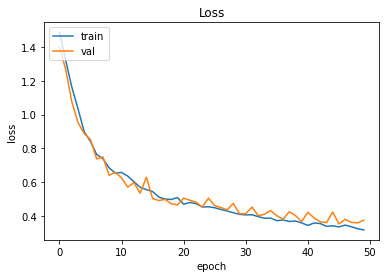

In [20]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_qq5_w79/assets


In [22]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root   6957664 Jul 14 13:54 model.tflite
